# Deep Learning Models  

This notebook contains the Deep Learning models we will use.

Here we are using two models:
1. LSTM
2. CNN1d

Importing relevant libraries

In [84]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Defining training parameters.

In [85]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
PATIENCE = 50

#### Data Loading and Directory Setup

Loads training and test data for multiple stocks. The data is read from CSV files located in the specified `data_dir`, and the individual stock datasets are concatenated into unified training (`train_df`) and testing (`test_df`) DataFrames.

The models will be saved in the directory specified by `save_dir`.


In [86]:
# Define directories for data and model saving
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
save_dir = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models"
save_dir_lstm=f"{save_dir}/lstm"
save_dir_cnn=f"{save_dir}/cnn"

stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA'] 

# Initialize lists to store training and test DataFrames
train_dfs, test_dfs = [], []

# Load training and testing data for each stock
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    train_stock_df = pd.read_csv(f"{stock_dir}/treino.csv", index_col=0)
    test_stock_df = pd.read_csv(f"{stock_dir}/teste.csv", index_col=0)

    train_stock_df.iloc[:, 3] = train_stock_df.iloc[:, 3].replace(-1, 0)
    test_stock_df.iloc[:, 3] = test_stock_df.iloc[:, 3].replace(-1, 0)

    # Add a new column to indicate the stock symbol
    # train_stock_df['Stock'] = stock
    # test_stock_df['Stock'] = stock

    # Append DataFrames to respective lists
    train_dfs.append(train_stock_df)
    test_dfs.append(test_stock_df)

# Concatenate all training and testing DataFrames
# train_df = pd.concat(train_dfs, ignore_index=False)
# test_df = pd.concat(test_dfs, ignore_index=False)

# Apply one-hot encoding
# encoder = OneHotEncoder(sparse_output=False)  
# stock_encoded = encoder.fit_transform(train_df[['Stock']])

# # Convert the encoded array to a DataFrame with proper column names
# stock_encoded_df = pd.DataFrame(stock_encoded, 
#                                 columns=encoder.get_feature_names_out(['Stock']),
#                                 index=train_df.index)
                
# # Concatenate the one-hot encoded columns with the original DataFrame
# train_df = pd.concat([train_df, stock_encoded_df], axis=1)

# # Drop the original 'Stock' column as it's now encoded
# train_df.drop(columns=['Stock'], inplace=True)

# # Apply the same transformation to the test set
# stock_encoded_test = encoder.transform(test_df[['Stock']])
# stock_encoded_test_df = pd.DataFrame(stock_encoded_test, 
#                                      columns=encoder.get_feature_names_out(['Stock']),
#                                      index=test_df.index)

# test_df = pd.concat([test_df, stock_encoded_test_df], axis=1)
# test_df.drop(columns=['Stock'], inplace=True)

# Now, train_df and test_df have one-hot encoded stock columns.

In [87]:
train_dfs[0].head()

,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1,2000-01-24,1.062769,1.071645,0,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
2,2000-01-26,1.087668,1.073247,0,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
3,2000-01-27,1.064080,1.072330,0,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
4,2000-01-28,1.036561,1.068753,0,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
5,2000-01-31,1.035250,1.065403,0,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


Label adjustment.

In [88]:
# # Replace -1 with 0 in the fourth column (label column) for train_df and test_df
# # train_df.iloc[:, 3] = train_df.iloc[:, 3].replace(-1, 0)
# # test_df.iloc[:, 3] = test_df.iloc[:, 3].replace(-1, 0)

# # Apply the same transformation to each individual DataFrame in test_dfs
# for train_df, test_df in zip(train_dfs, test_dfs):
#     train_dfs.iloc[:, 3] = train_df.iloc[:, 3].replace(-1, 0)
#     test_df.iloc[:, 3] = test_df.iloc[:, 3].replace(-1, 0)


Feature reshaping for model input.

In [135]:
# Extract features and labels
# train_features = train_df.iloc[:, 4:].values  # Shape: (n_samples, total_features)
# labels = train_df.iloc[:, 3].values          # Shape: (n_samples,)

# Separate columns: Normalize all except the last 4
# features_to_normalize = train_features[:, :-4]  # All columns except the last 4
# features_unchanged = train_features[:, -4:]    # Last 4 columns remain unchanged

# Apply StandardScaler only to the selected columns
# scaler = StandardScaler()
# scaler.fit(train_features)
# train_features = scaler.transform(train_features)

# Concatenate normalized and unchanged features back together
# train_features = np.hstack((normalized_features, features_unchanged))

# Reshape the feature matrix to (samples, timesteps, features)
# train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))

train_features, train_labels, test_features, test_labels = [], [], [], []
for train_df, test_df in zip(train_dfs, test_dfs):
    train_feature = train_df.iloc[:, 4:].values  # Shape: (n_samples, total_features)
    label = train_df.iloc[:, 3].values          # Shape: (n_samples,)
    
    # scaler = StandardScaler()
    # scaler.fit(train_feature)
    # train_feature = scaler.transform(train_feature)

    test_feature = test_df.iloc[:, 4:].values
    # test_feature = scaler.transform(test_feature)
    test_label = test_df.iloc[:, 3].values

    # compute differences
    train_feature = (train_feature[:, :-1] - train_feature[:, 1:])
    test_feature = (test_feature[:, :-1] - test_feature[:, 1:])

    train_features.append(train_feature)
    train_labels.append(label)
    test_features.append(test_feature)
    test_labels.append(test_label)

In [136]:
for feature in train_features:
    print(feature.shape)

(4735, 14)
(4743, 14)
(4808, 14)
(4808, 14)


Define history ploting method.

In [137]:
def plot_training_history(title, history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model_cnn.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{title}")
    

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

Defines EarlyStopping and ModelCheckpoint callbacks and a method to save a model. 

In [138]:
def define_early_stopping():
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',   # Monitor validation loss
        patience=PATIENCE,          # Stop training if val_loss doesn't improve for PATIENCE
        restore_best_weights=True,  # Restore the best model weights after stopping
        verbose=1
    )
    
    return early_stopping

# Define ModelCheckpoint callback
def save_best_model(model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"best_{model_name}.keras")

    checkpoint = ModelCheckpoint(
        filepath=save_path,  # Saves model as "best_cnn.h5" or "best_lstm.h5"
        monitor="val_loss",   # Track validation loss
        save_best_only=True,  # Save only the best model
        verbose=1             # Print when a model is saved
    )
    return checkpoint

def save_last_model(model, model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"last_{model_name}_{model.name}.keras")

    # Save the model
    model.save(save_path)

    print(f"Last model saved to: {save_path}")

Defines backtesting and evaluati

In [142]:
def backtest_strategy_np(prices, predictions, initial_cash=10000, price_index=0):
    cash = initial_cash
    position = 0
    portfolio_values = []
    
    for i in range(len(prices)):
        price = prices[i]
        signal = int(predictions[i][0])
        
        if signal == 1 and position == 0:
            shares_to_buy = int(cash // price)
            if shares_to_buy > 0:
                position = shares_to_buy
                cash -= position * price

        elif signal == 0 and position > 0:
            cash += position * price
            position = 0
        
        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)
    
    # Final liquidation if still holding a position
    if position > 0:
        if prices.ndim > 1:
            final_price = float(prices[-1, price_index])
        else:
            final_price = float(prices[-1])
        cash += position * final_price
        position = 0
    
    final_value = cash
    return portfolio_values, final_value


In [145]:
def results(models):
    for stock, model, stock_test_df, stock_test_label, test_df in zip(stocks, models, test_features, test_labels, test_dfs):
        X_test = stock_test_df
        y_test = stock_test_label

        print(f"Test results for stock: {stock}")
        print(model.name)

        y_pred_probs = model.predict(X_test, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Print the metrics
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print("Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print()

        prices = test_df.iloc[:,2].to_numpy()

        # Run the backtest simulation
        portfolio_values, final_value = backtest_strategy_np(prices, y_pred, initial_cash=10000, price_index=0)
        print(f"Final portfolio value for {stock}: R${final_value:.2f}")

        # Create a dual Y-axis plot
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

        # Plot stock prices on the left y-axis
        ax1.plot(prices, label='Stock Price', color='blue', linewidth=2)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Stock Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot portfolio values on the right y-axis
        ax2.plot(portfolio_values, label='Portfolio Value', color='orange', linestyle='--', linewidth=2)
        ax2.set_ylabel('Portfolio Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        # Title and legend
        plt.title(f'Stock Price and Portfolio Value Over Time for {stock}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        plt.show()
        print()


## Models

### LSTM  Model.

In [147]:
def lstm_model():
    # Define the model
    model_lstm = Sequential([
        Input(shape=(14, 1)),               # Explicit Input layer
        LSTM(32),                           # LSTM layer with 64 units
        Dense(32, activation='relu'),       # Fully connected dense layer
        Dense(1, activation='sigmoid')      # Output layer for binary classification
    ])

    # Compile the model with binary crossentropy loss and Adam optimizer
    model_lstm.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                    metrics=['accuracy'])
    
    return model_lstm

Train results for stock: BBAS3.SA


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6018 - loss: 0.6920
Epoch 1: val_loss improved from inf to 0.68142, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential_32.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6027 - loss: 0.6920 - val_accuracy: 0.7624 - val_loss: 0.6814
Epoch 2/200
113/119 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6461 - loss: 0.6858
Epoch 2: val_loss improved from 0.68142 to 0.64736, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential_32.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6465 - loss: 0.6856 - val_accuracy: 0.8342 - val_loss: 0.6474
Epoch 3/200
111/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7085 - loss: 0.6589
Epoch 3: val_loss improved from 0.64736 to 0.42875, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential

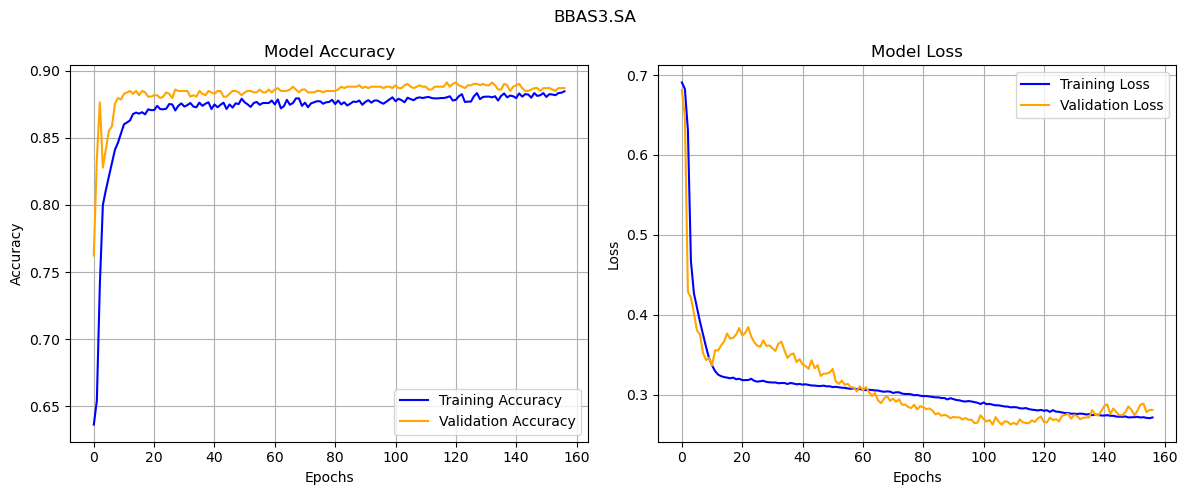

Train results for stock: CSNA3.SA


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
104/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5620 - loss: 0.6921
Epoch 1: val_loss improved from inf to 0.68399, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.SA_sequential_33.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5691 - loss: 0.6919 - val_accuracy: 0.7302 - val_loss: 0.6840
Epoch 2/200
109/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6196 - loss: 0.6848
Epoch 2: val_loss improved from 0.68399 to 0.65495, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.SA_sequential_33.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 0.6843 - val_accuracy: 0.7229 - val_loss: 0.6549
Epoch 3/200
105/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 0.6511
Epoch 3: val_loss improved from 0.65495 to 0.48723, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.S

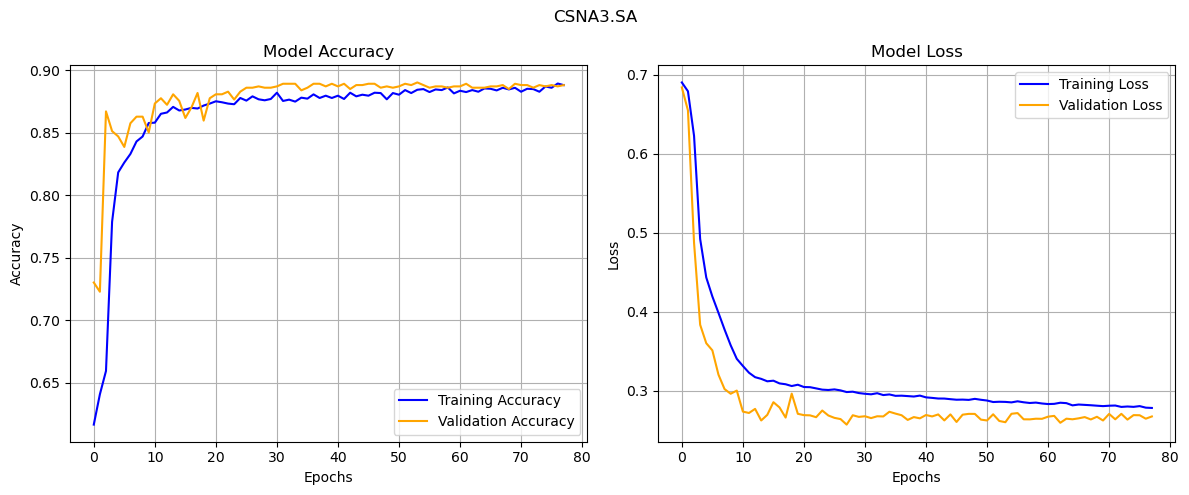

Train results for stock: PETR4.SA


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
115/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6534 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.68132, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.SA_sequential_34.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6539 - loss: 0.6903 - val_accuracy: 0.6694 - val_loss: 0.6813
Epoch 2/200
105/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 0.6799
Epoch 2: val_loss improved from 0.68132 to 0.63245, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.SA_sequential_34.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6351 - loss: 0.6788 - val_accuracy: 0.8046 - val_loss: 0.6325
Epoch 3/200
105/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7353 - loss: 0.6175
Epoch 3: val_loss improved from 0.63245 to 0.41777, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.S

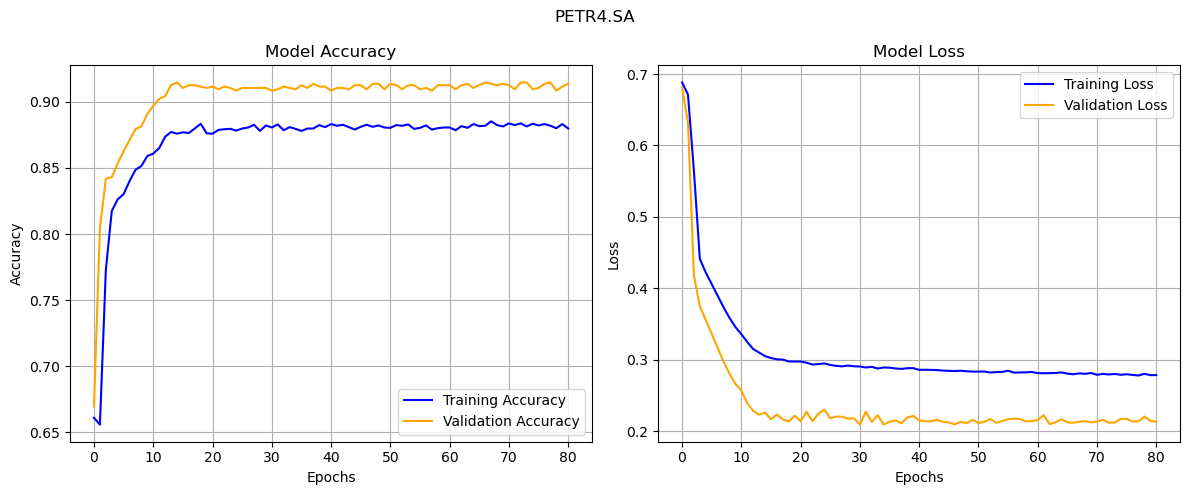

Train results for stock: VALE3.SA


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
109/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6992 - loss: 0.6876
Epoch 1: val_loss improved from inf to 0.66261, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.SA_sequential_35.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6960 - loss: 0.6871 - val_accuracy: 0.7516 - val_loss: 0.6626
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 0.6622
Epoch 2: val_loss improved from 0.66261 to 0.53061, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.SA_sequential_35.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6355 - loss: 0.6621 - val_accuracy: 0.8035 - val_loss: 0.5306
Epoch 3/200
 90/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6845 - loss: 0.5592
Epoch 3: val_loss improved from 0.53061 to 0.39671, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.S

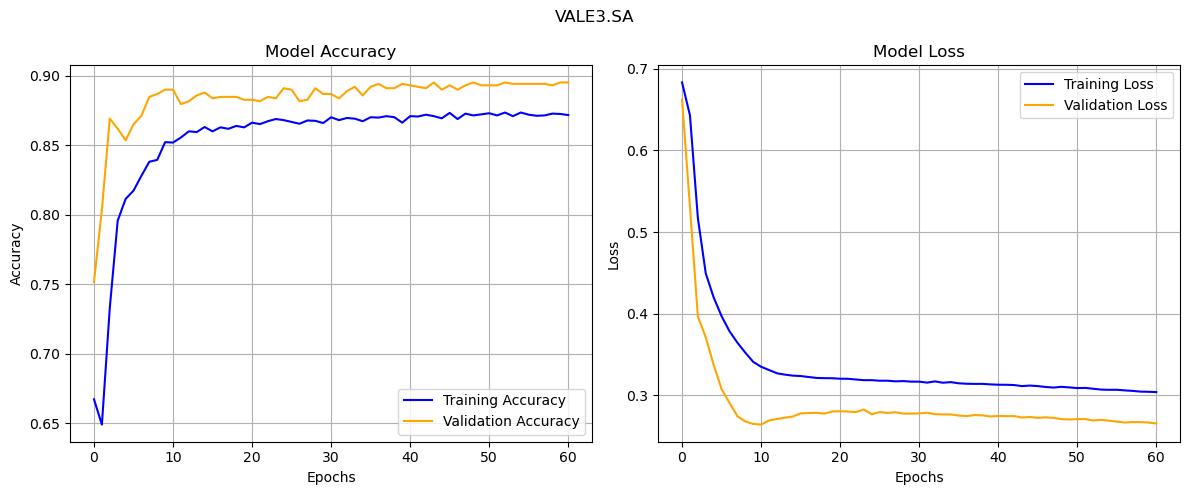

In [149]:
lstm_stock_models, lstm_stock_histories = [], []
for stock, stock_feature, stock_label in zip(stocks, train_features, train_labels):
    print(f"Train results for stock: {stock}")
    stock_model = lstm_model()

    stock_model.summary()

    lstm_checkpoint = save_best_model(f"lstm_{stock}_{stock_model.name}", save_dir_lstm)
    lstm_early_stopping = define_early_stopping()

    # Fit model
    history_lstm = stock_model.fit(
        stock_feature, stock_label,
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_split=0.2, 
        callbacks=[lstm_early_stopping, lstm_checkpoint] 
    )

    lstm_stock_models.append(stock_model)
    lstm_stock_histories.append(history_lstm)

    save_last_model(stock_model, f"lstm_{stock}", save_dir_lstm)

    plot_training_history(stock, history_lstm)


Evaluates LSTM Model for each stock.

Test results for stock: BBAS3.SA
sequential_32
Accuracy: 0.88
Precision: 0.85
Recall: 0.86
F1 Score: 0.85
Confusion Matrix:


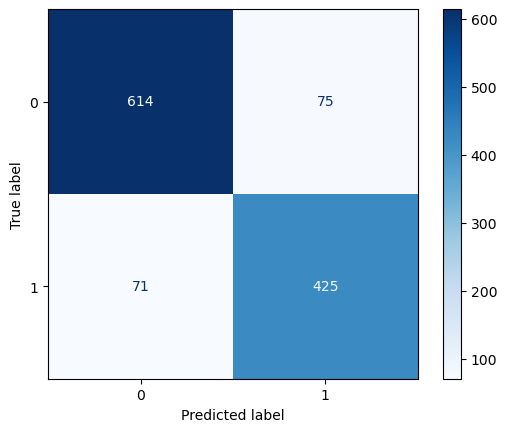


Final portfolio value for BBAS3.SA: R$63640.38


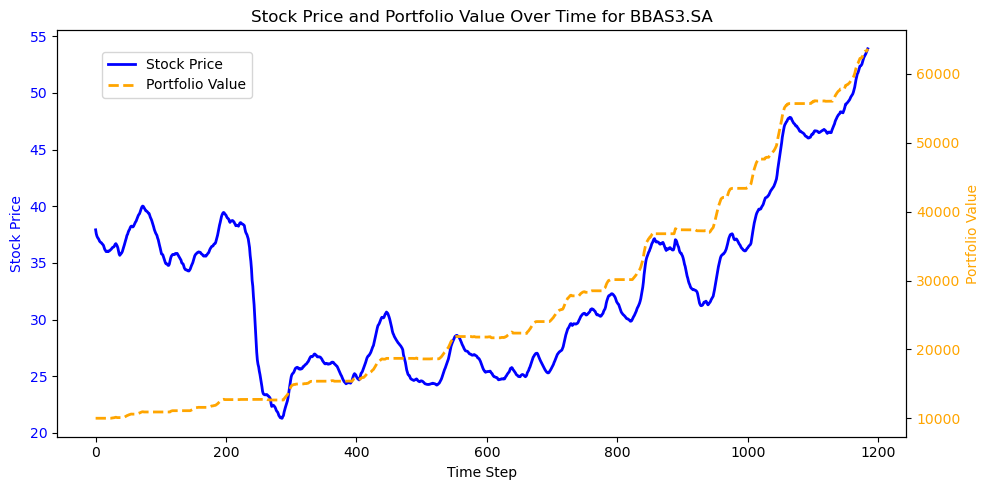


Test results for stock: CSNA3.SA
sequential_33
Accuracy: 0.86
Precision: 0.82
Recall: 0.86
F1 Score: 0.84
Confusion Matrix:


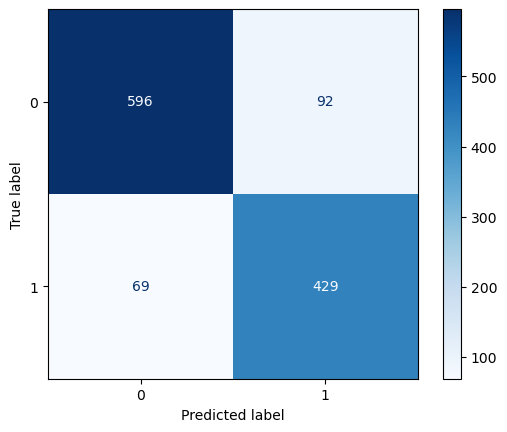


Final portfolio value for CSNA3.SA: R$257512.54


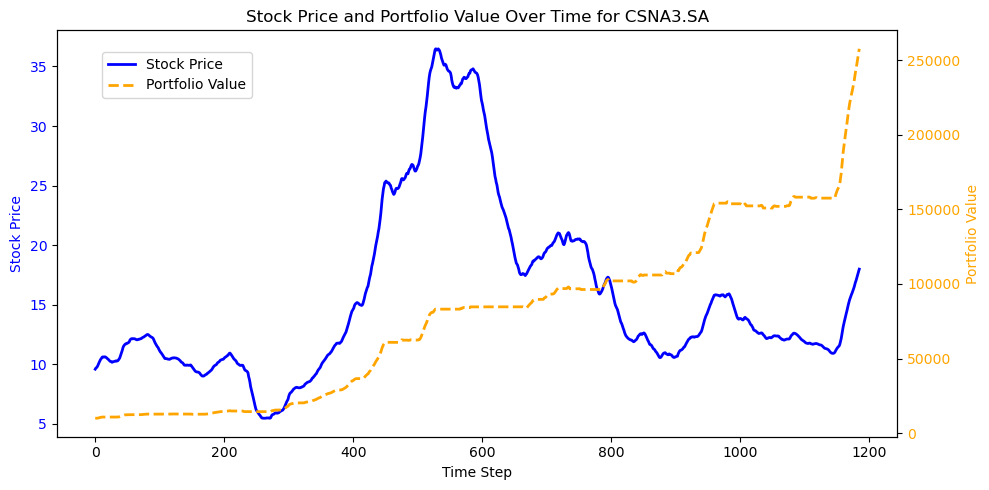


Test results for stock: PETR4.SA
sequential_34
Accuracy: 0.86
Precision: 0.84
Recall: 0.89
F1 Score: 0.87
Confusion Matrix:


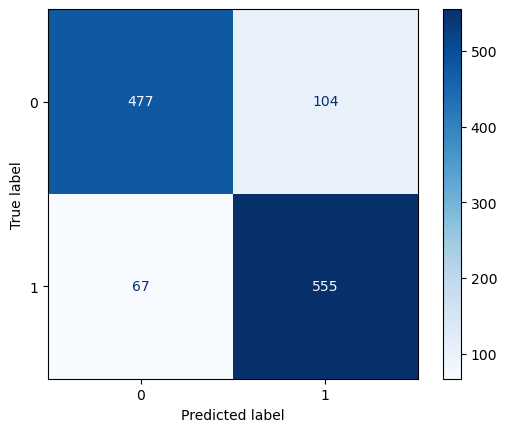


Final portfolio value for PETR4.SA: R$153478.75


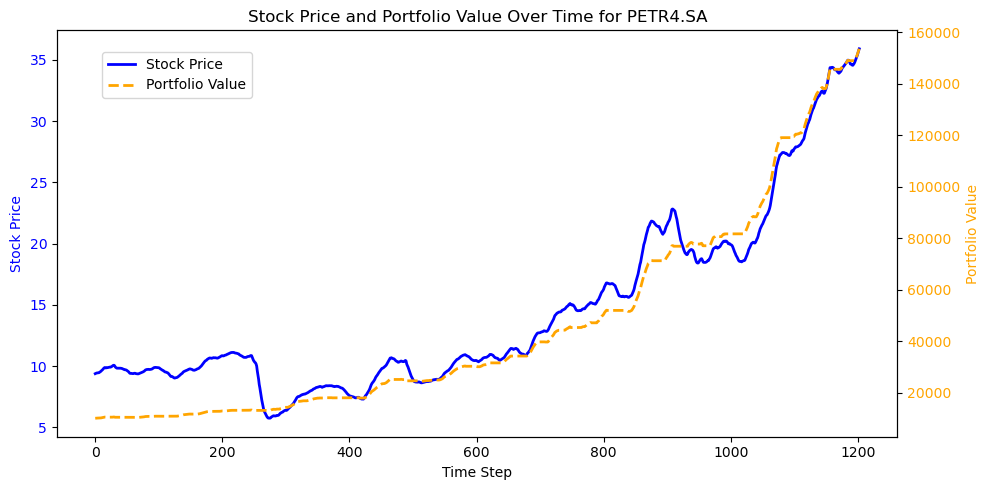


Test results for stock: VALE3.SA
sequential_35
Accuracy: 0.86
Precision: 0.87
Recall: 0.84
F1 Score: 0.85
Confusion Matrix:


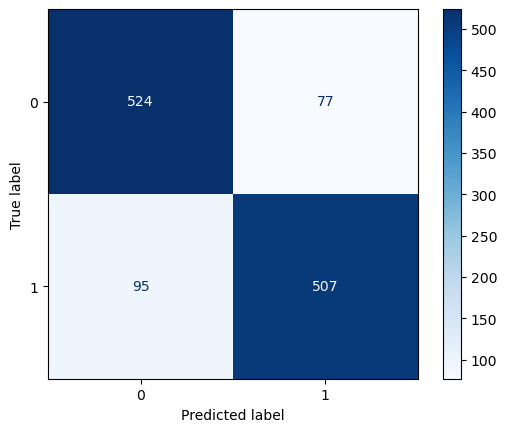


Final portfolio value for VALE3.SA: R$86418.62


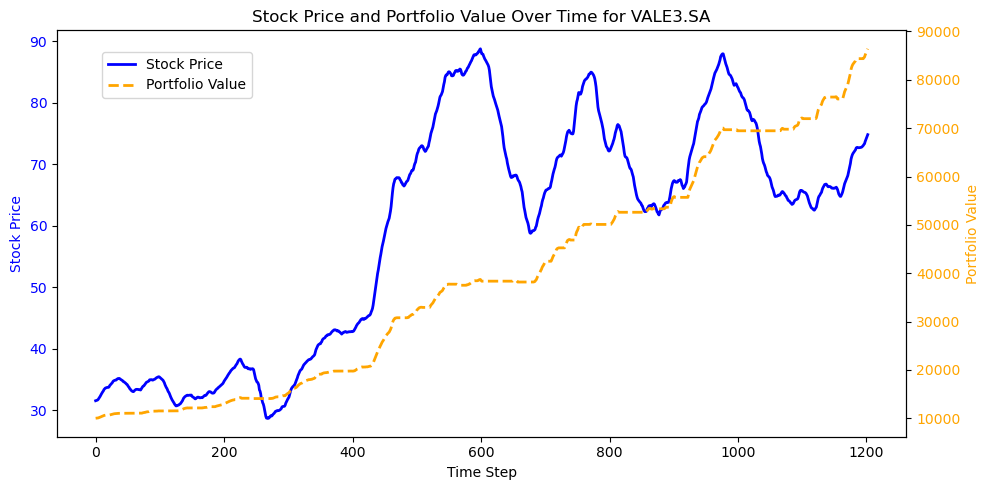

In [150]:
results(lstm_stock_models)

### CNN1d  Model.

In [139]:
def cnn_model():
    # Define the model
    model_cnn = Sequential([
        Input(shape=(14, 1)),                                   # Explicit Input layer
        Conv1D(filters=32, kernel_size=5, activation='relu'),   # 1D Convolutional layer
        MaxPooling1D(pool_size=2),                              # MaxPooling layer to reduce dimensionality
        Conv1D(filters=16, kernel_size=5, activation='relu'),   # Another Conv1D layer
        Flatten(),                                              # Flatten layer to transition from CNN to Dense
        Dense(16, activation='relu'),                           # Fully connected dense layer
        Dropout(0.3),                                           # Dropout to prevent overfitting
        Dense(1, activation='sigmoid')                          # Output layer for binary classification
    ])

    # Compile the model with binary crossentropy loss and Adam optimizer
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_cnn

Train results for stock: BBAS3.SA


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5470 - loss: 0.6783 
Epoch 1: val_loss improved from inf to 0.40939, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_BBAS3.SA_sequential_24.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5475 - loss: 0.6780 - val_accuracy: 0.8437 - val_loss: 0.4094
Epoch 2/200
 98/119 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.8018 - loss: 0.4764
Epoch 2: val_loss improved from 0.40939 to 0.29034, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_BBAS3.SA_sequential_24.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8042 - loss: 0.4682 - val_accuracy: 0.8828 - val_loss: 0.2903
Epoch 3/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.4202
Epoch 3: val_loss did not improve from 0.29034
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.8591 - loss: 0.3594 - val_accuracy: 0.8912 - val_lo

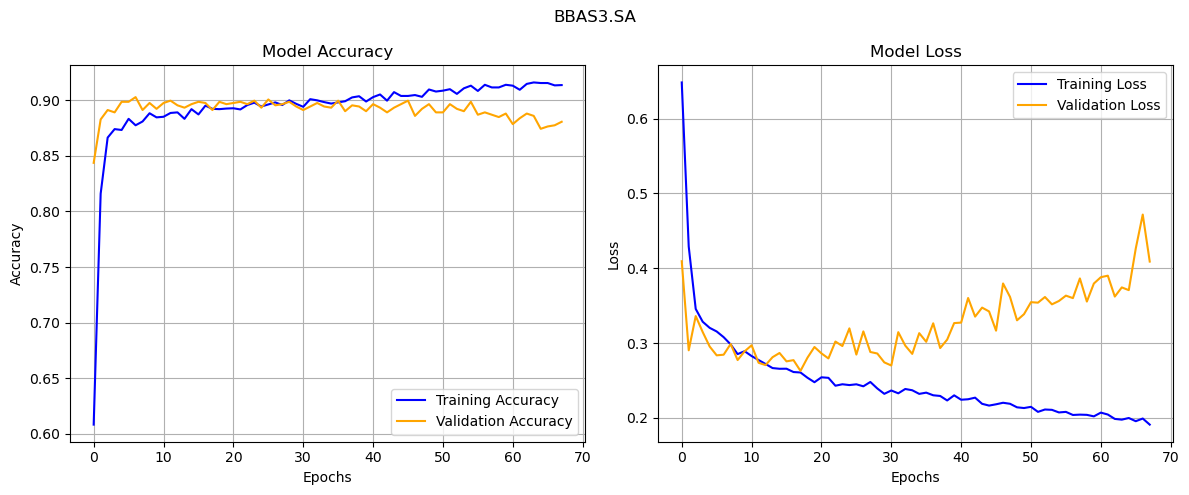

Train results for stock: CSNA3.SA


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5763 - loss: 0.6496    
Epoch 1: val_loss improved from inf to 0.43877, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3.SA_sequential_25.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5769 - loss: 0.6492 - val_accuracy: 0.8662 - val_loss: 0.4388
Epoch 2/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8438 - loss: 0.5374
Epoch 2: val_loss improved from 0.43877 to 0.30771, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3.SA_sequential_25.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.8432 - loss: 0.4532 - val_accuracy: 0.8683 - val_loss: 0.3077
Epoch 3/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7500 - loss: 0.4596
Epoch 3: val_loss improved from 0.30771 to 0.26097, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3

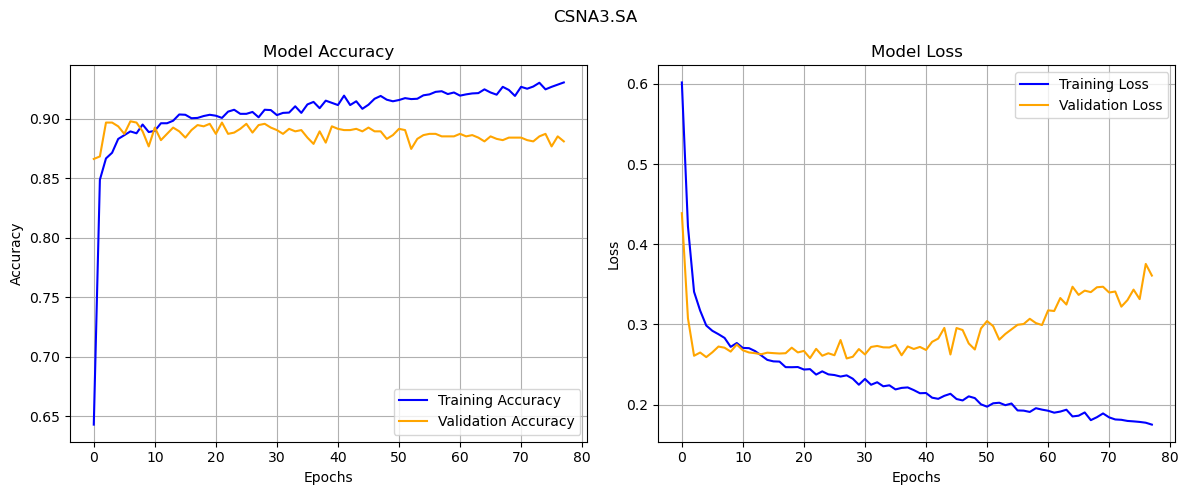

Train results for stock: PETR4.SA


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6076 - loss: 0.6622  
Epoch 1: val_loss improved from inf to 0.43264, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.SA_sequential_26.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6081 - loss: 0.6618 - val_accuracy: 0.8160 - val_loss: 0.4326
Epoch 2/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8438 - loss: 0.4596
Epoch 2: val_loss improved from 0.43264 to 0.23829, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.SA_sequential_26.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.8449 - loss: 0.4191 - val_accuracy: 0.9127 - val_loss: 0.2383
Epoch 3/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8750 - loss: 0.2724
Epoch 3: val_loss improved from 0.23829 to 0.21439, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.S

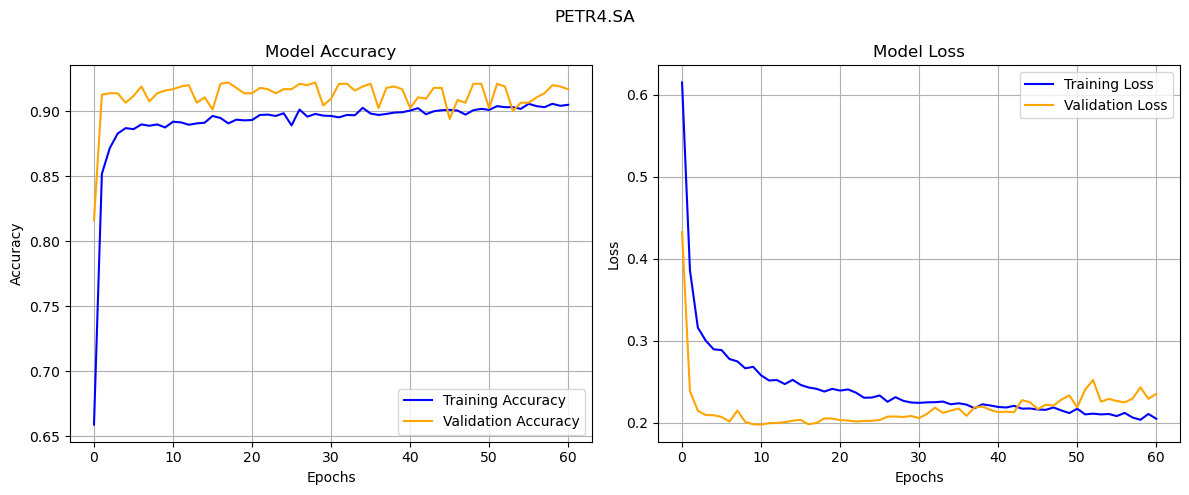

Train results for stock: VALE3.SA


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5864 - loss: 0.6462  
Epoch 1: val_loss improved from inf to 0.34019, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_VALE3.SA_sequential_27.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5871 - loss: 0.6457 - val_accuracy: 0.8701 - val_loss: 0.3402
Epoch 2/200
109/121 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8163 - loss: 0.4119
Epoch 2: val_loss improved from 0.34019 to 0.26650, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_VALE3.SA_sequential_27.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.8182 - loss: 0.4094 - val_accuracy: 0.8919 - val_loss: 0.2665
Epoch 3/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8125 - loss: 0.5294
Epoch 3: val_loss did not improve from 0.26650
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.8591 - loss: 0.3509 - val_accuracy: 0.8960 - val

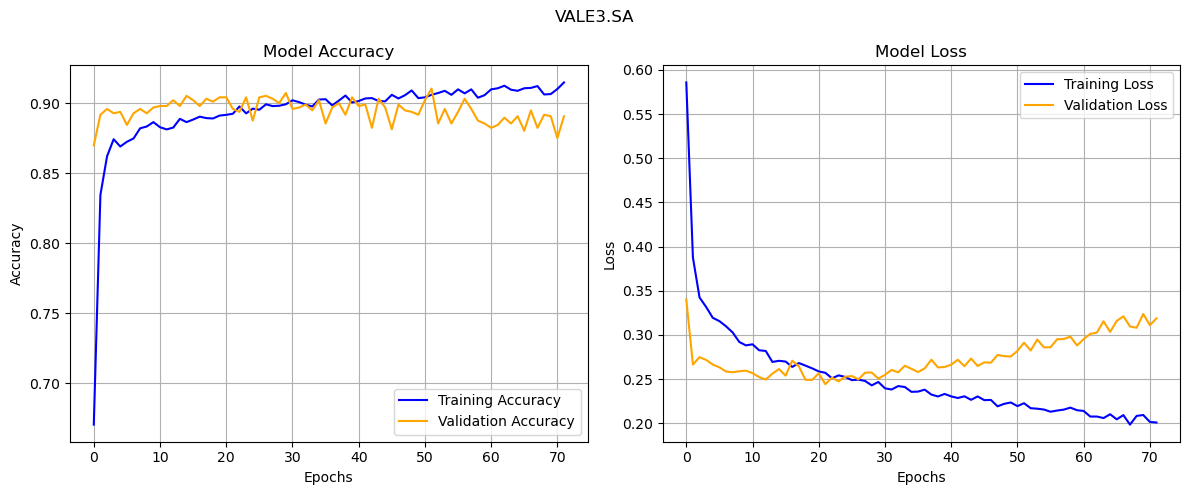

In [140]:
cnn_stock_models, cnn_stock_histories = [], []

for stock, stock_feature, stock_label in zip(stocks, train_features, train_labels):
    print(f"Train results for stock: {stock}")
    stock_model = cnn_model()

    stock_model.summary()

    cnn_checkpoint = save_best_model(f"cnn_{stock}_{stock_model.name}", save_dir_cnn)
    cnn_early_stopping = define_early_stopping()

    # Fit the model
    history_cnn = stock_model.fit(
        stock_feature, stock_label,
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_split=0.2, 
        callbacks=[cnn_early_stopping, cnn_checkpoint]  
    )
    
    cnn_stock_models.append(stock_model)
    cnn_stock_histories.append(history_cnn)

    save_last_model(stock_model, f"cnn_{stock}", save_dir_cnn)

    plot_training_history(stock, history_cnn)

Evaluates CNN1d Model for each stock.

Test results for stock: BBAS3.SA
sequential_24
Accuracy: 0.88
Precision: 0.83
Recall: 0.90
F1 Score: 0.87
Confusion Matrix:


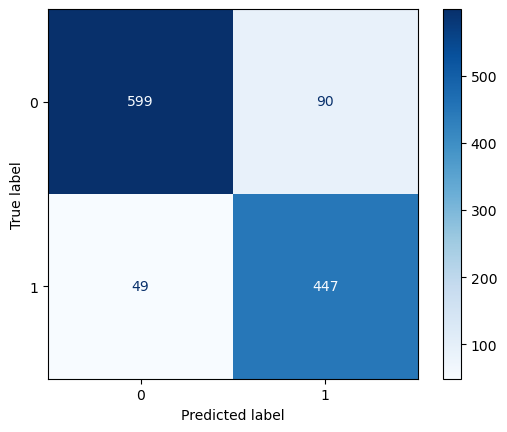


Final portfolio value for BBAS3.SA: R$63683.83


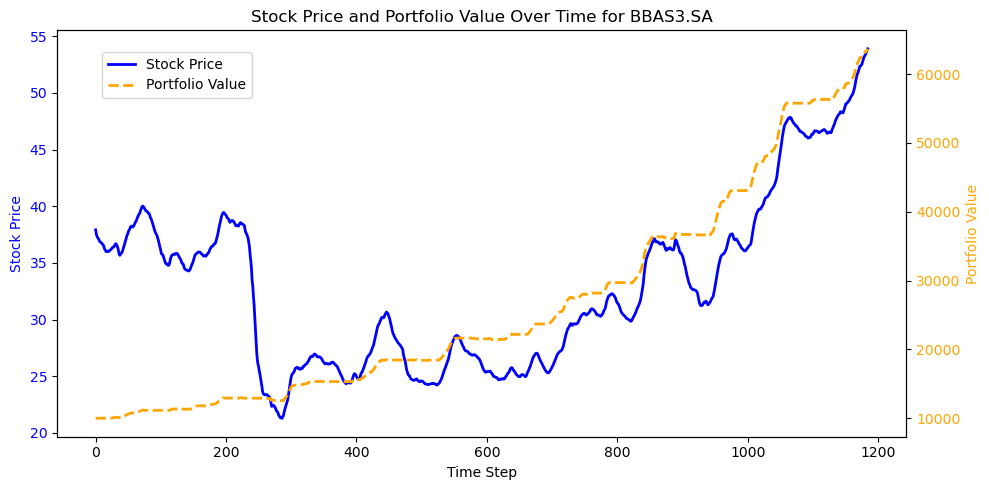


Test results for stock: CSNA3.SA
sequential_25
Accuracy: 0.89
Precision: 0.85
Recall: 0.88
F1 Score: 0.87
Confusion Matrix:


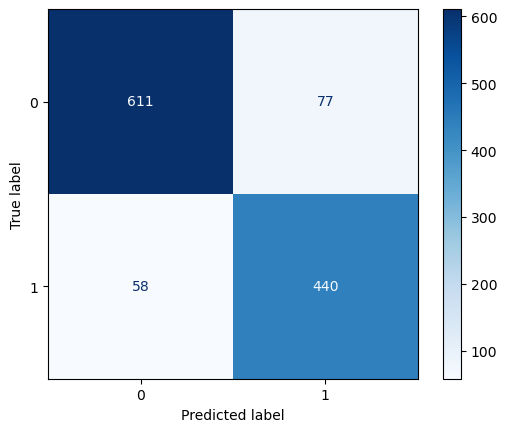


Final portfolio value for CSNA3.SA: R$272158.87


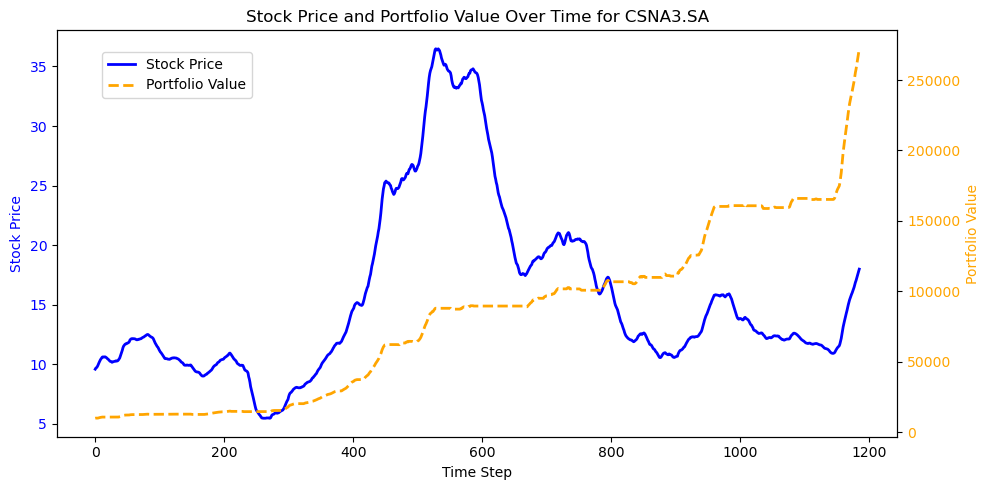


Test results for stock: PETR4.SA
sequential_26
Accuracy: 0.87
Precision: 0.87
Recall: 0.88
F1 Score: 0.87
Confusion Matrix:


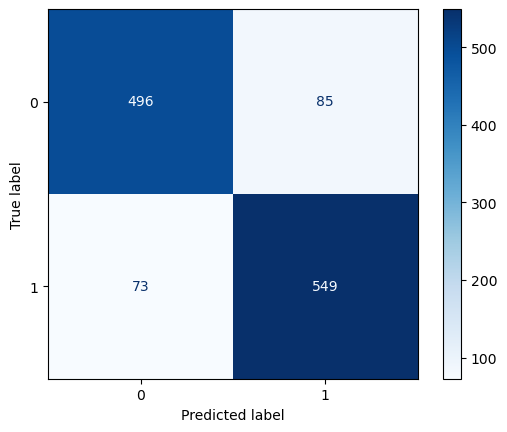


Final portfolio value for PETR4.SA: R$148197.30


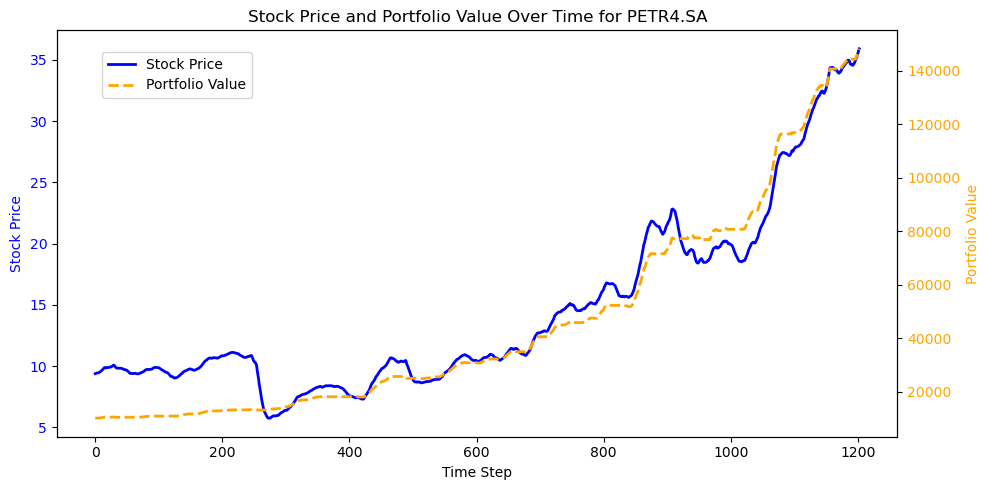


Test results for stock: VALE3.SA
sequential_27
Accuracy: 0.88
Precision: 0.88
Recall: 0.89
F1 Score: 0.88
Confusion Matrix:


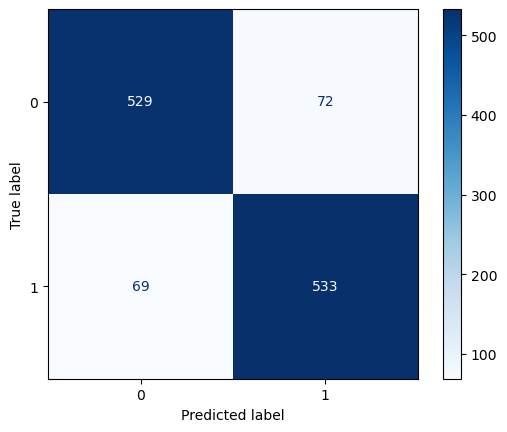


Final portfolio value for VALE3.SA: R$87416.22


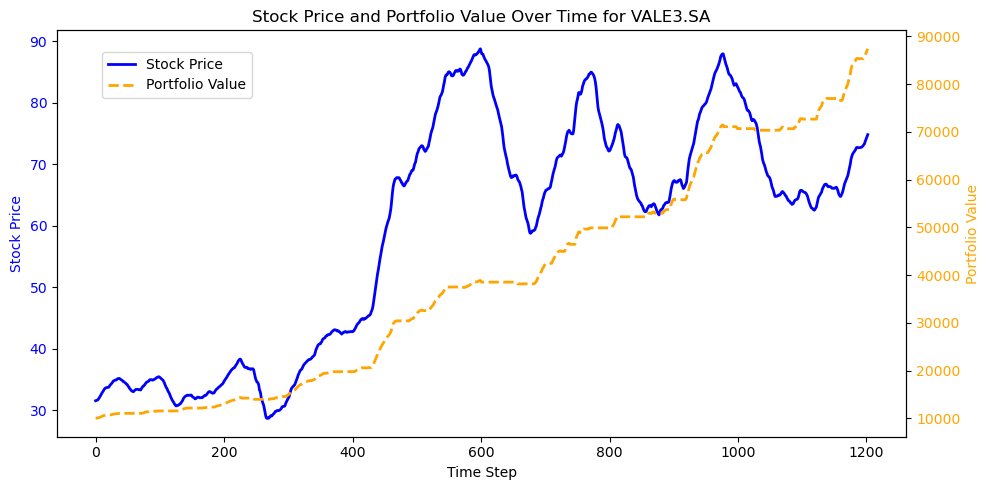

In [146]:
results(cnn_stock_models)